# **Data Pre-processing**

### **Import Libraries**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_samples, silhouette_score, adjusted_rand_score, accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle, Ellipse

import numpy as np
import pandas as pd
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Load Dataset**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/train_dataset.zip')
data.head()

,LTE/5g Category,Time,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,AR/VR/Gaming,Healthcare,Industry 4.0,IoT Devices,Public Safety,Smart City & Home,Smart Transportation,Smartphone,slice Type
0,14,0,0.000001,10,1,0,0,1,0,0,0,0,1,0,0,0,3
1,18,20,0.001000,100,0,1,1,0,1,0,0,0,0,0,0,0,1
2,17,14,0.000001,300,0,1,0,1,0,0,0,0,0,0,0,1,1
3,3,17,0.010000,100,0,1,0,1,0,0,0,0,0,0,0,1,1
4,9,4,0.010000,50,1,0,0,1,0,0,0,0,0,1,0,0,2


### **Class Distribution Analysis**

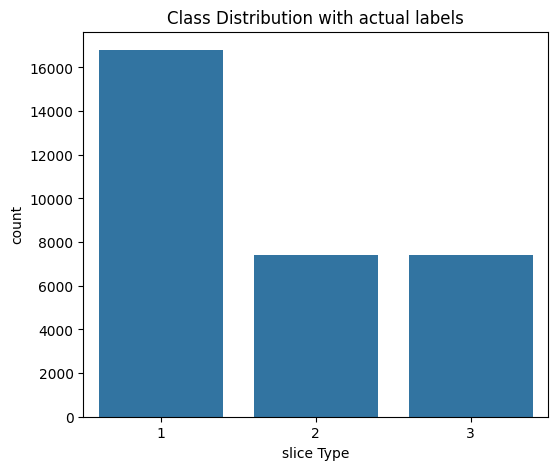

In [4]:
plt.figure(figsize=(6, 5))
sns.countplot(x=data['slice Type'])
plt.title('Class Distribution with actual labels')
plt.show()

#### **Experiment 7 with undersampling**

Activate this section of Experiment 7 when willing to perform undersampling before proceeding with the further steps.

In [5]:
# Identify the majority class
majority_class = data['slice Type'].value_counts().idxmax()

# Count the number of data points in the majority class
majority_count = data['slice Type'].value_counts()[majority_class]

# Count the number of data points in the other two classes
minority_count = data['slice Type'].value_counts().min()

# Calculate the number of data points to remove from the majority class
num_to_remove = majority_count - minority_count

# Randomly select data points from the majority class to remove
majority_indices = data[data['slice Type'] == majority_class].index
remove_indices = np.random.choice(majority_indices, size=num_to_remove, replace=False)

# Remove the selected data points from the DataFrame
balanced_data = data.drop(remove_indices)

In [6]:
data = balanced_data
data.head()

,LTE/5g Category,Time,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,AR/VR/Gaming,Healthcare,Industry 4.0,IoT Devices,Public Safety,Smart City & Home,Smart Transportation,Smartphone,slice Type
0,14,0,0.000001,10,1,0,0,1,0,0,0,0,1,0,0,0,3
4,9,4,0.010000,50,1,0,0,1,0,0,0,0,0,1,0,0,2
5,19,2,0.000001,10,1,0,0,1,0,0,1,0,0,0,0,0,3
6,15,2,0.010000,300,1,0,1,0,0,0,0,1,0,0,0,0,2
9,13,10,0.001000,150,0,1,0,1,0,0,0,0,0,0,0,1,1


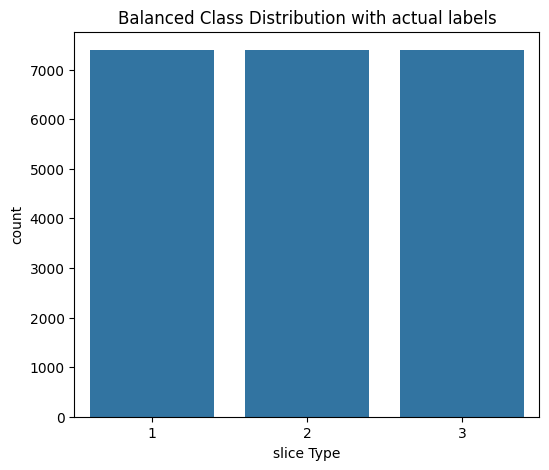

In [7]:
plt.figure(figsize=(6, 5))
sns.countplot(x=data['slice Type'])
plt.title('Balanced Class Distribution with actual labels')
plt.show()

### **Relevant Feature Selection**

In [8]:
# Select relevant features for clustering (excluding LTE/5g Category and Time)
# X = data.drop(['LTE/5g Category', 'Time'], axis=1)
# features = ['Packet Loss Rate', 'Packet delay', 'IoT',	'LTE/5G',	'GBR',	'Non-GBR', 'AR/VR/Gaming',	'Healthcare',	'Industry 4.0', 'IoT Devices',	'Public Safety',	'Smart City & Home',	'Smart Transportation',	'Smartphone']
features = ['Packet Loss Rate', 'Packet delay', 'IoT',	'LTE/5G',	'GBR',	'Non-GBR']
# features = ['Packet Loss Rate', 'IoT',	'LTE/5G',	'GBR',	'Non-GBR']
# features = ['Packet Loss Rate', 'Packet delay']
# features = ['Packet Loss Rate']

### **Define X and y**

In [9]:
X = data[features]
X

,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR
0,0.000001,10,1,0,0,1
4,0.010000,50,1,0,0,1
5,0.000001,10,1,0,0,1
6,0.010000,300,1,0,1,0
9,0.001000,150,0,1,0,1
...,...,...,...,...,...,...
31576,0.010000,50,1,0,0,1
31579,0.010000,50,1,0,0,1
31580,0.010000,300,1,0,1,0
31581,0.000001,10,1,0,0,1


In [10]:
y = data['slice Type']
y

0        3
4        2
5        3
6        2
9        1
        ..
31576    2
31579    2
31580    2
31581    3
31582    3
Name: slice Type, Length: 22176, dtype: int64

In [11]:
np.unique(y)

array([1, 2, 3])

### **Ground Truth Calculation**

#### **Ground Truth Slice 1**

In [12]:
# Group data by label "slice 0"
grouped_data_slice1 = data[data['slice Type'] == 1]
grouped_data_slice1

,LTE/5g Category,Time,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,AR/VR/Gaming,Healthcare,Industry 4.0,IoT Devices,Public Safety,Smart City & Home,Smart Transportation,Smartphone,slice Type
9,13,10,0.001000,150,0,1,0,1,0,0,0,0,0,0,0,1,1
10,3,4,0.000001,300,0,1,0,1,0,0,0,0,0,0,0,1,1
14,15,20,0.001000,100,0,1,1,0,1,0,0,0,0,0,0,0,1
15,1,16,0.010000,75,0,1,0,1,0,0,0,0,0,0,0,1,1
19,8,21,0.001000,50,0,1,0,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31565,1,8,0.001000,150,0,1,0,1,0,0,0,0,0,0,0,1,1
31566,9,17,0.010000,100,0,1,0,1,0,0,0,0,0,0,0,1,1
31569,6,9,0.000001,60,0,1,1,0,0,0,0,0,0,0,0,1,1
31571,8,23,0.001000,150,0,1,0,1,0,0,0,0,0,0,0,1,1


In [13]:
# Create 14-dimensional vectors
grouped_data_slice1_vec = grouped_data_slice1[features].values
grouped_data_slice1_vec

array([[1.0e-03, 1.5e+02, 0.0e+00, 1.0e+00, 0.0e+00, 1.0e+00],
       [1.0e-06, 3.0e+02, 0.0e+00, 1.0e+00, 0.0e+00, 1.0e+00],
       [1.0e-03, 1.0e+02, 0.0e+00, 1.0e+00, 1.0e+00, 0.0e+00],
       ...,
       [1.0e-06, 6.0e+01, 0.0e+00, 1.0e+00, 1.0e+00, 0.0e+00],
       [1.0e-03, 1.5e+02, 0.0e+00, 1.0e+00, 0.0e+00, 1.0e+00],
       [1.0e-03, 1.0e+02, 0.0e+00, 1.0e+00, 1.0e+00, 0.0e+00]])

In [14]:
# Calculate Average
GT_slice1 = np.mean(grouped_data_slice1_vec, axis=0)
GT_slice1

array([2.40205560e-03, 1.33358360e+02, 0.00000000e+00, 1.00000000e+00,
       5.08116883e-01, 4.91883117e-01])

#### **Ground Truth Slice 2**

In [15]:
# Group data by label "slice 0"
grouped_data_slice2 = data[data['slice Type'] == 2]
grouped_data_slice2

,LTE/5g Category,Time,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,AR/VR/Gaming,Healthcare,Industry 4.0,IoT Devices,Public Safety,Smart City & Home,Smart Transportation,Smartphone,slice Type
4,9,4,0.010,50,1,0,0,1,0,0,0,0,0,1,0,0,2
6,15,2,0.010,300,1,0,1,0,0,0,0,1,0,0,0,0,2
12,7,3,0.010,50,1,0,0,1,0,0,0,0,0,1,0,0,2
26,9,17,0.010,50,1,0,0,1,0,0,0,0,0,1,0,0,2
42,3,10,0.001,50,1,0,1,0,0,0,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31562,6,18,0.010,50,1,0,0,1,0,0,0,0,0,1,0,0,2
31567,7,18,0.010,300,1,0,1,0,0,0,0,1,0,0,0,0,2
31576,1,12,0.010,50,1,0,0,1,0,0,0,0,0,1,0,0,2
31579,12,7,0.010,50,1,0,0,1,0,0,0,0,0,1,0,0,2


In [16]:
# Create 14-dimensional vectors
grouped_data_slice2_vec = grouped_data_slice2[features].values
grouped_data_slice2_vec

array([[1.e-02, 5.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       [1.e-02, 3.e+02, 1.e+00, 0.e+00, 1.e+00, 0.e+00],
       [1.e-02, 5.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       ...,
       [1.e-02, 5.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       [1.e-02, 5.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       [1.e-02, 3.e+02, 1.e+00, 0.e+00, 1.e+00, 0.e+00]])

In [17]:
# Calculate Average
GT_slice2 = np.mean(grouped_data_slice2_vec, axis=0)
GT_slice2

array([7.75243506e-03, 1.73985390e+02, 1.00000000e+00, 0.00000000e+00,
       7.45670996e-01, 2.54329004e-01])

#### **Ground Truth Slice 3**

In [18]:
# Group data by label "slice 0"
grouped_data_slice3 = data[data['slice Type'] == 3]
grouped_data_slice3

,LTE/5g Category,Time,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,AR/VR/Gaming,Healthcare,Industry 4.0,IoT Devices,Public Safety,Smart City & Home,Smart Transportation,Smartphone,slice Type
0,14,0,0.000001,10,1,0,0,1,0,0,0,0,1,0,0,0,3
5,19,2,0.000001,10,1,0,0,1,0,0,1,0,0,0,0,0,3
11,7,17,0.000001,10,1,0,0,1,0,1,0,0,0,0,0,0,3
17,9,20,0.000001,10,1,0,0,1,0,0,0,0,0,0,1,0,3
18,7,15,0.000001,10,1,0,0,1,0,1,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31553,12,23,0.000001,10,1,0,0,1,0,1,0,0,0,0,0,0,3
31570,17,0,0.000001,10,1,0,0,1,0,0,1,0,0,0,0,0,3
31572,14,17,0.000001,10,1,0,0,1,0,0,1,0,0,0,0,0,3
31581,8,1,0.000001,10,1,0,0,1,0,1,0,0,0,0,0,0,3


In [19]:
# Create 14-dimensional vectors
grouped_data_slice3_vec = grouped_data_slice3[features].values
grouped_data_slice3_vec

array([[1.e-06, 1.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       [1.e-06, 1.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       [1.e-06, 1.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       ...,
       [1.e-06, 1.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       [1.e-06, 1.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00],
       [1.e-06, 1.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00]])

In [20]:
# Calculate Average
GT_slice3 = np.mean(grouped_data_slice3_vec, axis=0)
GT_slice3

array([1.e-06, 1.e+01, 1.e+00, 0.e+00, 0.e+00, 1.e+00])

#### **Plot Ground Truth**

In [21]:
# Combine the centroids into a single array
GT_centroids = np.vstack((GT_slice1, GT_slice2, GT_slice3))
GT_centroids

array([[2.40205560e-03, 1.33358360e+02, 0.00000000e+00, 1.00000000e+00,
        5.08116883e-01, 4.91883117e-01],
       [7.75243506e-03, 1.73985390e+02, 1.00000000e+00, 0.00000000e+00,
        7.45670996e-01, 2.54329004e-01],
       [1.00000000e-06, 1.00000000e+01, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]])

In [22]:
# Apply PCA to reduce the dimensionality to 3 dimensions
pca = PCA(n_components=3)
centroids_3d = pca.fit_transform(GT_centroids)
centroids_3d

array([[-2.75797894e+01,  8.70281387e-01,  4.66385446e-15],
       [-6.82042016e+01, -6.54688611e-01,  4.66385446e-15],
       [ 9.57839910e+01, -2.15592777e-01,  4.66385446e-15]])

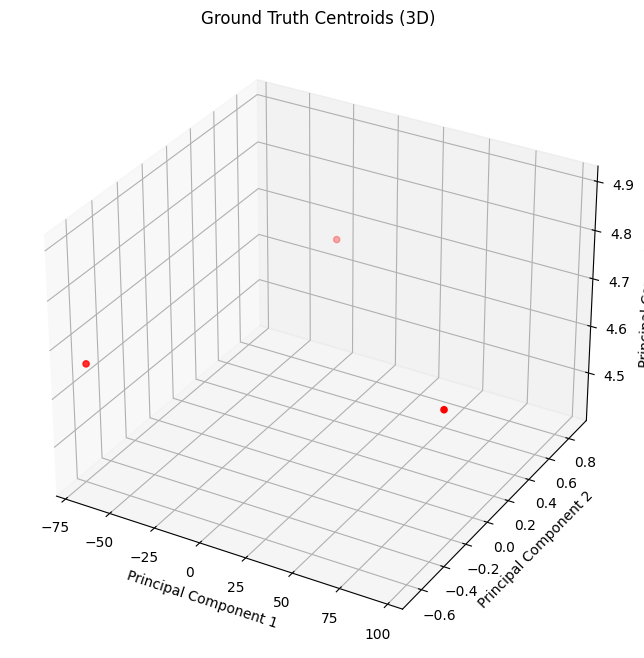

In [23]:
# Plot the centroids in 3D space
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], c='r', marker='o')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.title('Ground Truth Centroids (3D)')
plt.show()

### **Datasplit - X, X_train and X_test**

In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
X_train

,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR
587,0.000001,10,1,0,0,1
16564,0.001000,150,0,1,0,1
20938,0.000001,10,1,0,0,1
6687,0.001000,100,0,1,1,0
3174,0.000001,10,1,0,0,1
...,...,...,...,...,...,...
17093,0.000001,10,1,0,0,1
30767,0.001000,50,1,0,1,0
7748,0.010000,300,1,0,1,0
1252,0.010000,300,1,0,1,0


In [25]:
X_test

,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR
21547,0.000001,10,1,0,0,1
20323,0.000001,10,1,0,0,1
15840,0.000001,10,1,0,0,1
3572,0.001000,50,1,0,1,0
29016,0.000001,10,1,0,0,1
...,...,...,...,...,...,...
28045,0.010000,50,1,0,0,1
21227,0.001000,100,0,1,1,0
24599,0.010000,300,1,0,1,0
31095,0.000001,60,0,1,1,0


In [26]:
y_train

587      3
16564    1
20938    3
6687     1
3174     3
        ..
17093    3
30767    2
7748     2
1252     2
22500    1
Name: slice Type, Length: 19958, dtype: int64

In [27]:
y_test

21547    3
20323    3
15840    3
3572     2
29016    3
        ..
28045    2
21227    1
24599    2
31095    1
29648    1
Name: slice Type, Length: 2218, dtype: int64

In [28]:
# tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2 dimensions
# X_tsne_vec = tsne.fit_transform(X)
# X_tsne_vec

In [29]:
# # Map cluster labels to X_train data points
# X_tsne = pd.DataFrame({'Feature1': X_tsne_vec[:, 0], 'Feature2': X_tsne_vec[:, 1]})
# X_tsne

In [30]:
# # Split the dataset into training and testing sets
# X_tsne_train, X_tsne_val = train_test_split(X_tsne, test_size=0.1, random_state=42)
# X_tsne_train

In [31]:
# X_tsne_val

# **EDA**

## Pair Plots

In [32]:
# sns.pairplot(X)
# plt.suptitle('Pairwise Scatter Plots', y=1.02)
# plt.show()

In [33]:
# sns.pairplot(X_tsne)
# plt.suptitle('Pairwise Scatter Plots', y=1.02)
# plt.show()

## Heatmaps

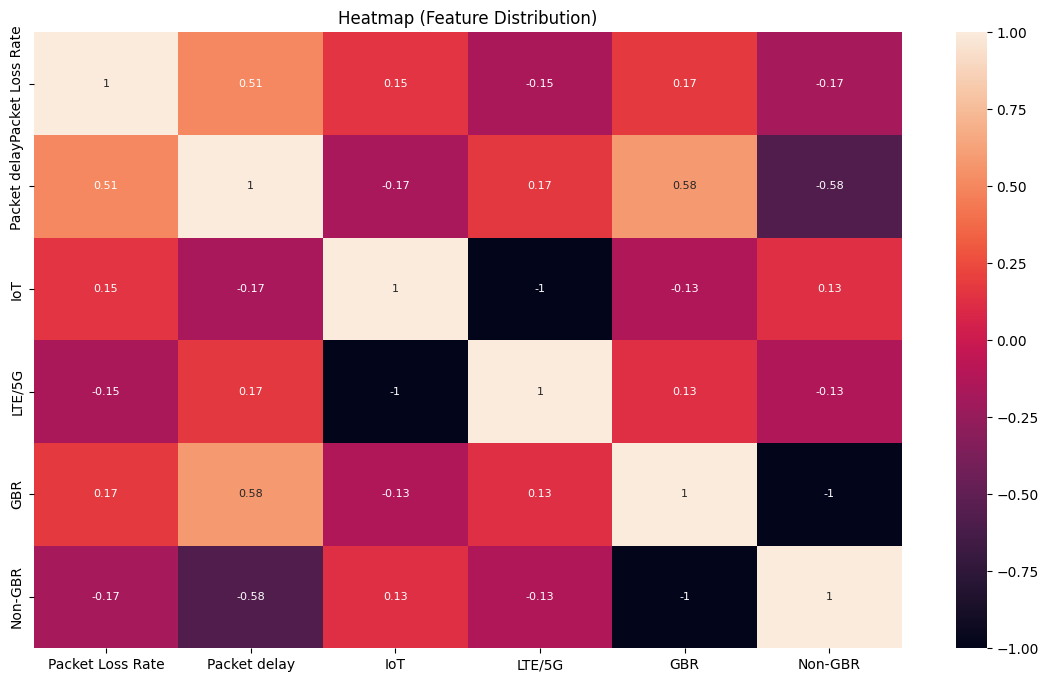

In [34]:
# Create a heatmap for the correlation matrix of all features
plt.figure(figsize=(14, 8))
sns.heatmap(X_train.corr(), annot=True, annot_kws={"size": 8})
plt.title('Heatmap (Feature Distribution)')
plt.show()

# **Data Modelling and Analysis**

## **Model Training**

In [35]:
# Create a KMeans model
kmeans_model = KMeans(n_clusters=3, random_state=42)

# Fit the model to the training data
best_model = kmeans_model.fit(X_train)
best_model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

## **Hyperparameter Tuning**

In [36]:
# # Initialize KMeans model
# kmeans = KMeans()

# # Define hyperparameters to tune
# param_grid = {
#     'init': ['k-means++', 'random'],
#     'n_clusters': [3],
#     'max_iter': [100, 200, 300, 400, 500],
#     # 'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
#     'tol': [1e-6],
#     'algorithm': ['auto', 'full'],
#     # 'n_jobs': [-1],  # Use all available CPU cores
#     'random_state': [42]
# }

# # Perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(kmeans, param_grid, cv=20, scoring='neg_mean_squared_error')
# grid_search.fit(X_train)

# # Get best hyperparameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Print best hyperparameters
# print("\n\nBest Hyperparameters:")
# print(best_params)

# # Print best model
# print("\nBest Model:")
# best_model

## **Model Labels**

In [37]:
kmeans_model_labels = best_model.labels_
kmeans_model_labels

array([1, 0, 1, ..., 2, 2, 0], dtype=int32)

In [38]:
kmeans_model_labels_aligned = kmeans_model_labels + 1
kmeans_model_labels_aligned

array([2, 1, 2, ..., 3, 3, 1], dtype=int32)

In [39]:
len(kmeans_model_labels_aligned)

19958

In [40]:
np.unique(kmeans_model_labels_aligned)

array([1, 2, 3], dtype=int32)

## **Model Centroids**

In [41]:
kmeans_model_centroids = best_model.cluster_centers_
kmeans_model_centroids

array([[ 3.88543594e-03,  1.03683346e+02, -1.75415238e-14,
         1.00000000e+00,  5.05433409e-01,  4.94566591e-01],
       [ 1.69671643e-03,  2.71880508e+01,  8.81124427e-01,
         1.18875573e-01,  2.07437434e-01,  7.92562566e-01],
       [ 7.13976596e-03,  3.00000000e+02,  7.13947991e-01,
         2.86052009e-01,  8.60305179e-01,  1.39694821e-01]])

In [42]:
# Function to format a single value
def format_value(value):
    # Format value to have at least three digits with leading zeros if necessary
    formatted_value = f"{value:.3e}"
    # Replace any instances of "e-0" with "e-" to ensure consistent formatting
    # formatted_value = formatted_value.replace("e-0", "e-")
    # Return the formatted value
    return formatted_value

# Function to format an array
def format_array(array):
    # Define the number of elements per line
    elements_per_line = 3

    # Iterate over each row in the array
    formatted_rows = []
    for row in array:
        # Format each value in the row and join them with a comma and newline, printing only a certain number of elements per line
        formatted_elements = [format_value(value) for value in row]
        formatted_row = ', '.join(formatted_elements[:elements_per_line])

        # Check if there are more elements to print
        if len(formatted_elements) > elements_per_line:
            # Print remaining elements on new lines
            for i in range(elements_per_line, len(formatted_elements), elements_per_line):
                formatted_row += ',\n\t' + ', '.join(formatted_elements[i:i + elements_per_line])

        # Enclose the formatted row within double square brackets
        formatted_row = "[" + formatted_row + "]"

        # Append the formatted row to the list of formatted rows
        formatted_rows.append(formatted_row)

    # Combine the rows into a string with proper array formatting
    formatted_string = "[" + ",\n       ".join(formatted_rows) + "]"
    return formatted_string

In [43]:
# Format the given array
formatted_centroids_array_before = format_array(kmeans_model_centroids)
print("array("+formatted_centroids_array_before+")")

array([[3.885e-03, 1.037e+02, -1.754e-14,
	1.000e+00, 5.054e-01, 4.946e-01],
       [1.697e-03, 2.719e+01, 8.811e-01,
	1.189e-01, 2.074e-01, 7.926e-01],
       [7.140e-03, 3.000e+02, 7.139e-01,
	2.861e-01, 8.603e-01, 1.397e-01]])


In [44]:
C1 = kmeans_model_centroids[0]
C1

array([ 3.88543594e-03,  1.03683346e+02, -1.75415238e-14,  1.00000000e+00,
        5.05433409e-01,  4.94566591e-01])

In [45]:
C2 = kmeans_model_centroids[1]
C2

array([1.69671643e-03, 2.71880508e+01, 8.81124427e-01, 1.18875573e-01,
       2.07437434e-01, 7.92562566e-01])

In [46]:
C3 = kmeans_model_centroids[2]
C3

array([7.13976596e-03, 3.00000000e+02, 7.13947991e-01, 2.86052009e-01,
       8.60305179e-01, 1.39694821e-01])

## **Initialization of an empty array before Centroid Mapping based on Ground Truths**

In [47]:
feature_lists = [features, features, features]
feature_lists

[['Packet Loss Rate', 'Packet delay', 'IoT', 'LTE/5G', 'GBR', 'Non-GBR'],
 ['Packet Loss Rate', 'Packet delay', 'IoT', 'LTE/5G', 'GBR', 'Non-GBR'],
 ['Packet Loss Rate', 'Packet delay', 'IoT', 'LTE/5G', 'GBR', 'Non-GBR']]

In [48]:
len(features)

6

In [49]:
# Determine the number of columns (max length of feature lists)
num_columns = max(len(feature_list) for feature_list in feature_lists)
num_columns

6

In [50]:
# Create an empty NumPy array with 3 rows and num_columns columns, filled with 0.0
arr = np.zeros((3, num_columns))
print(arr)
print(arr.dtype)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
float64


## **Minimum Distance of C1 from Ground Truths**

In [51]:
dist_C1_GT_slice1 = np.linalg.norm(C1 - GT_slice1)
dist_C1_GT_slice1

29.675014700180242

In [52]:
dist_C1_GT_slice2 = np.linalg.norm(C1 - GT_slice2)
dist_C1_GT_slice2

70.31708742035458

In [53]:
dist_C1_GT_slice3 = np.linalg.norm(C1 - GT_slice3)
dist_C1_GT_slice3

93.69674622381473

In [54]:
# Determine the closest centroid
min_dist_C1 = min(dist_C1_GT_slice1, dist_C1_GT_slice2, dist_C1_GT_slice3)

if min_dist_C1 == dist_C1_GT_slice1:
    closest_centroid_C1 = "Slice 1"
    arr[0] = C1
elif min_dist_C1 == dist_C1_GT_slice2:
    closest_centroid_C1 = "Slice 2"
    arr[0] = C2
else:
    closest_centroid_C1 = "Slice 3"
    arr[0] = C3

print("C1 has minimum distance of ", min_dist_C1, "from the Model's Centroid/Cluster", closest_centroid_C1)
arr

C1 has minimum distance of  29.675014700180242 from the Model's Centroid/Cluster Slice 1


array([[ 3.88543594e-03,  1.03683346e+02, -1.75415238e-14,
         1.00000000e+00,  5.05433409e-01,  4.94566591e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## **Minimum Distance of C2 from Ground Truths**

In [55]:
dist_C2_GT_slice1 = np.linalg.norm(C2 - GT_slice1)
dist_C2_GT_slice1

106.17847345191636

In [56]:
dist_C2_GT_slice2 = np.linalg.norm(C2 - GT_slice2)
dist_C2_GT_slice2

146.79940866502494

In [57]:
dist_C2_GT_slice3 = np.linalg.norm(C2 - GT_slice3)
dist_C2_GT_slice3

17.19137618432458

In [58]:
# Determine the closest centroid
min_dist_C2 = min(dist_C2_GT_slice1, dist_C2_GT_slice2, dist_C2_GT_slice3)

if min_dist_C2 == dist_C2_GT_slice1:
    closest_centroid_C2 = "Slice 1"
    arr[1] = C1
elif min_dist_C2 == dist_C2_GT_slice2:
    closest_centroid_C2 = "Slice 2"
    arr[1] = C2
else:
    closest_centroid_C2 = "Slice 3"
    arr[1] = C3

print("C2 has minimum distance of ", min_dist_C2, "from the Model's Centroid/Cluster", closest_centroid_C2)
arr

C2 has minimum distance of  17.19137618432458 from the Model's Centroid/Cluster Slice 3


array([[ 3.88543594e-03,  1.03683346e+02, -1.75415238e-14,
         1.00000000e+00,  5.05433409e-01,  4.94566591e-01],
       [ 7.13976596e-03,  3.00000000e+02,  7.13947991e-01,
         2.86052009e-01,  8.60305179e-01,  1.39694821e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## **Minimum Distance of C3 from Ground Truths**

In [59]:
dist_C3_GT_slice1 = np.linalg.norm(C3 - GT_slice1)
dist_C3_GT_slice1

166.64544275539276

In [60]:
dist_C3_GT_slice2 = np.linalg.norm(C3 - GT_slice2)
dist_C3_GT_slice2

126.0153640058035

In [61]:
dist_C3_GT_slice3 = np.linalg.norm(C3 - GT_slice3)
dist_C3_GT_slice3

290.0028343869511

In [62]:
# Determine the closest centroid
min_dist_C3 = min(dist_C3_GT_slice1, dist_C3_GT_slice2, dist_C3_GT_slice3)

if min_dist_C3 == dist_C3_GT_slice1:
    closest_centroid_C3 = "Slice 1"
    arr[2] = C1
elif min_dist_C3 == dist_C3_GT_slice2:
    closest_centroid_C3 = "Slice 2"
    arr[2] = C2
else:
    closest_centroid_C3 = "Slice 3"
    arr[2] = C3

print("C3 has minimum distance of ", min_dist_C3, "from the Model's Centroid/Cluster", closest_centroid_C3)
arr

C3 has minimum distance of  126.0153640058035 from the Model's Centroid/Cluster Slice 2


array([[ 3.88543594e-03,  1.03683346e+02, -1.75415238e-14,
         1.00000000e+00,  5.05433409e-01,  4.94566591e-01],
       [ 7.13976596e-03,  3.00000000e+02,  7.13947991e-01,
         2.86052009e-01,  8.60305179e-01,  1.39694821e-01],
       [ 1.69671643e-03,  2.71880508e+01,  8.81124427e-01,
         1.18875573e-01,  2.07437434e-01,  7.92562566e-01]])

## **Model Centroids Mapping to Labels**

In [63]:
print("C1 has minimum distance of ", min_dist_C1, "from the Model's Centroid/Cluster", closest_centroid_C1)
print("C2 has minimum distance of ", min_dist_C2, "from the Model's Centroid/Cluster", closest_centroid_C2)
print("C3 has minimum distance of ", min_dist_C3, "from the Model's Centroid/Cluster", closest_centroid_C3)

C1 has minimum distance of  29.675014700180242 from the Model's Centroid/Cluster Slice 1
C2 has minimum distance of  17.19137618432458 from the Model's Centroid/Cluster Slice 3
C3 has minimum distance of  126.0153640058035 from the Model's Centroid/Cluster Slice 2


In [64]:
best_model

KMeans(n_clusters=3, random_state=42)

In [65]:
kmeans_model_mod = best_model
kmeans_model_mod

KMeans(n_clusters=3, random_state=42)

In [66]:
kmeans_model_mod.cluster_centers_ = arr

In [67]:
kmeans_model_centroids_mapped = kmeans_model_mod.cluster_centers_
kmeans_model_centroids_mapped

array([[ 3.88543594e-03,  1.03683346e+02, -1.75415238e-14,
         1.00000000e+00,  5.05433409e-01,  4.94566591e-01],
       [ 7.13976596e-03,  3.00000000e+02,  7.13947991e-01,
         2.86052009e-01,  8.60305179e-01,  1.39694821e-01],
       [ 1.69671643e-03,  2.71880508e+01,  8.81124427e-01,
         1.18875573e-01,  2.07437434e-01,  7.92562566e-01]])

In [68]:
# Format the given array
formatted_centroids_array_after = format_array(kmeans_model_centroids_mapped)
print("array("+formatted_centroids_array_after+")")

array([[3.885e-03, 1.037e+02, -1.754e-14,
	1.000e+00, 5.054e-01, 4.946e-01],
       [7.140e-03, 3.000e+02, 7.139e-01,
	2.861e-01, 8.603e-01, 1.397e-01],
       [1.697e-03, 2.719e+01, 8.811e-01,
	1.189e-01, 2.074e-01, 7.926e-01]])


## **Model Testing**

In [69]:
# Predict the labels for the test data
# y_pred = kmeans_model.predict(X_test)
y_pred = kmeans_model_mod.predict(X_test)
y_pred

array([2, 2, 2, ..., 1, 2, 0], dtype=int32)

In [70]:
y_pred_aligned = y_pred + 1
y_pred_aligned

array([3, 3, 3, ..., 2, 3, 1], dtype=int32)

In [71]:
len(y_pred_aligned)

2218

In [72]:
np.unique(y_pred_aligned)

array([1, 2, 3], dtype=int32)

## **Update testing dataset with labels**

In [73]:
# Get the column names from the original DataFrame
X_test_column_names = X_test.columns.tolist()

# Convert X_test to a pandas DataFrame
# X_test_df = pd.DataFrame(X_test, columns=X_test_column_names)

# Create a copy to avoid modifying the original DataFrame
X_test_with_labels = X_test.copy()

# Resetting indices to avoid alignment issues
X_test_with_labels.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# y_pred.reset_index(drop=True, inplace=True)

actual_label = pd.Series(y_test, name='actual_label')
predicted_label = pd.Series(y_pred_aligned, name='predicted_label')

# Include the 'predicted labels' as a new column in the DataFrame
X_test_with_labels['actual_label'] = actual_label

# Include the 'predicted labels' as a new column in the DataFrame
X_test_with_labels['predicted_label'] = predicted_label

In [74]:
# Display the Updated Table
X_test_with_labels[:20]

,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,actual_label,predicted_label
0,0.000001,10,1,0,0,1,3,3
1,0.000001,10,1,0,0,1,3,3
2,0.000001,10,1,0,0,1,3,3
3,0.001000,50,1,0,1,0,2,3
4,0.000001,10,1,0,0,1,3,3
5,0.001000,100,0,1,1,0,1,1
6,0.010000,300,1,0,1,0,2,2
7,0.010000,100,0,1,0,1,1,1
8,0.001000,50,1,0,1,0,2,3
9,0.000001,10,1,0,0,1,3,3


## **Predicted Label Analysis**

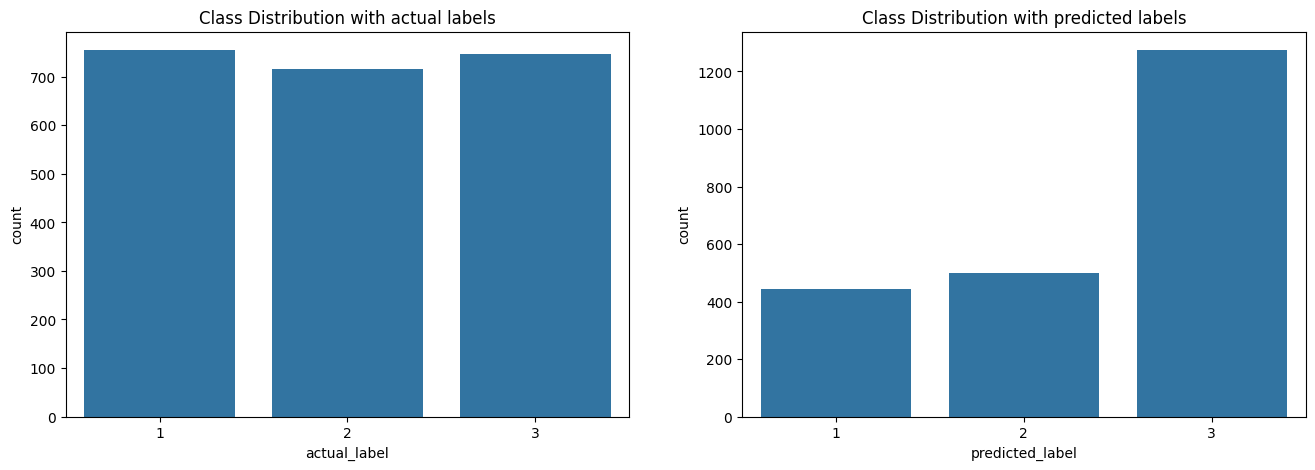

In [75]:
# Class Distribution

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.countplot(x=actual_label, ax=axs[0])
axs[0].set_title('Class Distribution with actual labels')

sns.countplot(x=predicted_label, ax=axs[1])
axs[1].set_title('Class Distribution with predicted labels')

plt.show()

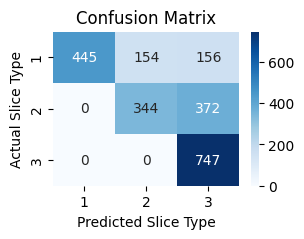

In [76]:
# Confusion Matrix
plt.figure(figsize=(3, 2))
cm = confusion_matrix(actual_label, predicted_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_label), yticklabels=np.unique(predicted_label))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Slice Type')
plt.ylabel('Actual Slice Type')
plt.show()

In [77]:
# Calculate accuracy
print("Accuracy", accuracy_score(actual_label, predicted_label))

# Calculate precision
print("Precision", precision_score(actual_label, predicted_label, average='weighted'))

# Calculate recall
print("Recall", recall_score(actual_label, predicted_label, average='weighted'))

# Calculate F1-score
print("F1-score", f1_score(actual_label, predicted_label, average='weighted'))

Accuracy 0.6925157799819658
Precision 0.7607035450985505
Recall 0.6925157799819658
F1-score 0.6842509788918265


In [78]:
conf_matrix = cm
conf_matrix

array([[445, 154, 156],
       [  0, 344, 372],
       [  0,   0, 747]])

In [79]:
# True Positives (TP) for each class
TP_class0 = conf_matrix[0, 0]
TP_class1 = conf_matrix[1, 1]
TP_class2 = conf_matrix[2, 2]

# False Positives (FP) for each class
FP_class0 = np.sum(conf_matrix[0, :]) - TP_class0
FP_class1 = np.sum(conf_matrix[1, :]) - TP_class1
FP_class2 = np.sum(conf_matrix[2, :]) - TP_class2

# False Negatives (FN) for each class
FN_class0 = np.sum(conf_matrix[:, 0]) - TP_class0
FN_class1 = np.sum(conf_matrix[:, 1]) - TP_class1
FN_class2 = np.sum(conf_matrix[:, 2]) - TP_class2

# True Negatives (TN) for each class
TN_class0 = np.sum(conf_matrix) - TP_class0 - FP_class0 - FN_class0
TN_class1 = np.sum(conf_matrix) - TP_class1 - FP_class1 - FN_class1
TN_class2 = np.sum(conf_matrix) - TP_class2 - FP_class2 - FN_class2

# Overall True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
TP = TP_class0 + TP_class1 + TP_class2
FP = FP_class0 + FP_class1 + FP_class2
FN = FN_class0 + FN_class1 + FN_class2
TN = TN_class0 + TN_class1 + TN_class2

# Display the values
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Negatives (TN):", TN)

True Positives (TP): 1536
False Positives (FP): 682
False Negatives (FN): 682
True Negatives (TN): 3754


In [80]:
acc = (TP + TN)/(TP + TN + FP + FN)
acc

0.7950105199879771

In [81]:
pres = TP/(TP + FP)
pres

0.6925157799819658

In [82]:
rec = TP/(TP + FN)
rec

0.6925157799819658

In [83]:
f1 = 2 * ((pres * rec)/(pres + rec))
f1

0.6925157799819658

# **SYNC NOTEBOOKS**

In [84]:
%cp '/content/drive/MyDrive/Colab Notebooks/Exp5 & 7 - Slice_Identification_UnSupML.ipynb' '/content/drive/MyDrive/Network_Slicing_with_ML_repo/Network-Slicing-with-ML/Notebooks/'